# DeepLander: Thruster Intelligence for Safe Lunar Descent

---



##Installing the required packages and importing the libraries

### Installing Gymnasium

In [ ]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


### Importing the libraries

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

##Building the AI

### Creating the architecture of the Neural Network

In [ ]:
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed=42):
        super(Network, self).__init__()
        torch.manual_seed(seed)

        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, action_size)
        )

    def forward(self, state):
        return self.model(state)


##Training the AI

### Setting up the environment

In [ ]:
import gymnasium as gym
env = gym.make('LunarLander-v3')
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


### Initializing the hyperparameters

In [ ]:
learning_rate = 5e-4
minibatch_size = 100
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

### Implementing Experience Replay

In [ ]:
from collections import deque

class ReplayMemory:
    def __init__(self, capacity):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.memory = deque(maxlen=capacity)

    def push(self, event):
        self.memory.append(event)

    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences]).astype(np.uint8)).float().to(self.device)
        return states, next_states, actions, rewards, dones

    def __len__(self):
        return len(self.memory)

### Implementing the DQN class

In [ ]:
class Agent():

  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    self.local_qnetwork = Network(state_size, action_size).to(self.device)
    self.target_qnetwork = Network(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = ReplayMemory(replay_buffer_size)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    self.memory.push((state, action, reward, next_state, done))
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(100)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      action_values = self.local_qnetwork(state)
    self.local_qnetwork.train()
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * next_q_targets * (1 - dones)
    q_expected = self.local_qnetwork(states).gather(1, actions)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

### Initializing the DQN agent

In [ ]:
agent = Agent(state_size, number_actions)

### Training the DQN agent

In [ ]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.995
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)
all_episode_scores = []

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  all_episode_scores.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
  if np.mean(scores_on_100_episodes) >= 200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break

Episode 100	Average Score: -137.93
Episode 200	Average Score: -115.93
Episode 300	Average Score: -104.98
Episode 400	Average Score: -57.33
Episode 500	Average Score: 2.74
Episode 600	Average Score: 46.30
Episode 700	Average Score: 84.20
Episode 800	Average Score: 10.49
Episode 900	Average Score: -41.06
Episode 1000	Average Score: 38.43
Episode 1100	Average Score: 98.95
Episode 1200	Average Score: 54.79
Episode 1300	Average Score: 36.41
Episode 1400	Average Score: 65.14
Episode 1500	Average Score: 17.62
Episode 1600	Average Score: 96.64
Episode 1700	Average Score: 78.49
Episode 1800	Average Score: 103.88
Episode 1900	Average Score: 125.78
Episode 2000	Average Score: 141.16


## Visualizing the performance

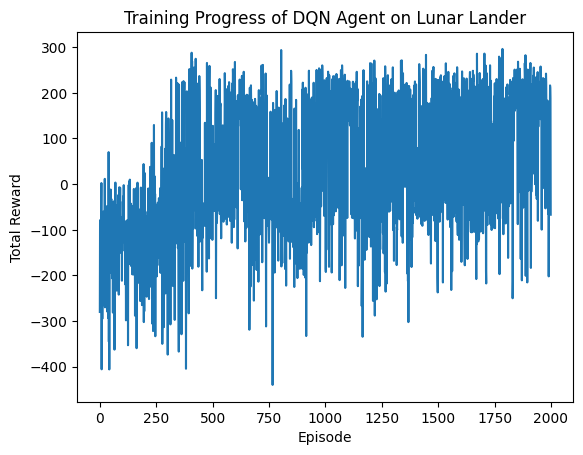

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_episode_scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress of DQN Agent on Lunar Lander')
plt.show()

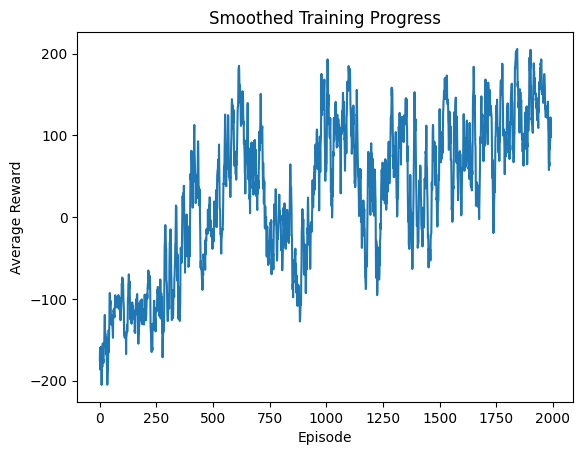

In [ ]:
def moving_average(x, window=10):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.plot(moving_average(x=all_episode_scores, window=10))
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Smoothed Training Progress')
plt.show()

##Visualizing the results

In [ ]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()


In [ ]:
def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()